# Test on stimulated signals (off-source)

In [1]:
import sys
sys.path.append('..')
from gwtoolkit.gw import WaveformDataset
from gwtoolkit.torch import (WaveformDatasetTorch, Normalize_params, Patching_data, ToTensor)
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import itertools
import numpy

import matplotlib.pyplot as plt

In [2]:
# 1. Init for WaveformDataset
sampling_frequency = 4096     # [Hz], sampling rate
duration = 8                  # [sec], duration of a sample
conversion = 'BBH'
waveform_approximant = 'IMRPhenomPv2'
# waveform_approximant = 'SEOBNRv4P' ## TODO
# waveform_approximant = 'IMRPhenomPv2_NRTidal'
# waveform_approximant = 'IMRPhenomXP'
reference_frequency = 50.
minimum_frequency = 20.
waveform_arguments = dict(waveform_approximant=waveform_approximant,
                          reference_frequency=reference_frequency,
                          minimum_frequency=minimum_frequency)
base = 'bilby'
dets = ['H1', 'L1'][:1]

filename = '../tests/gw/demo.prior'   # default prior file

In [3]:
# waveform dataset
wfd = WaveformDataset(sampling_frequency=sampling_frequency,
                      duration=duration,
                      conversion=conversion)

wfd.load_prior_source_detector(
    filename=filename,
    base=base,
    dets=dets,
    waveform_arguments=waveform_arguments)

Using priors in ../tests/gw/demo.prior


In [11]:
data_dir = './dataset/'
# 准备取 8sec 真实数据的数据
wfd.dets['H1'].load_from_GWOSC(data_dir, duration, selected_hdf_file_ratio=0.05)

ValueError: invalid literal for int() with base 10: ''

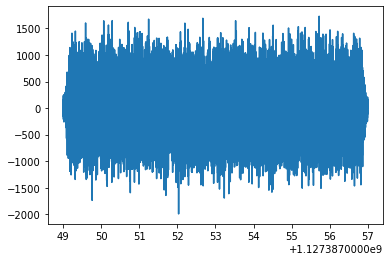

In [110]:
# 从真实数据中随机采样一段真实噪声数据, 并计算其 PSD
wfd.dets['H1'].update_time_domain_strain_from_GWOSC(seg_sec=2)   # seg_sec 表示计算 PSD 的切段长度
noise = wfd.dets['H1'].time_domain_whitened_strain

# 根据真实噪声的 PSD，进行白化后的噪声数据
plt.plot(wfd.dets['H1'].time_array, noise)

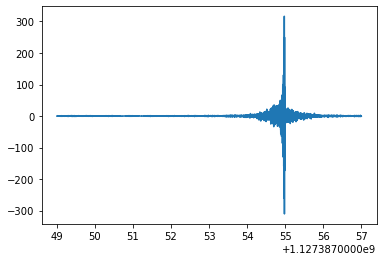

In [118]:
# 从先验参数空间中中随机采样出一个偏振波形
wfd._update_waveform()

# 将偏振波形投影到与噪声的 GPS 时间相匹配的探测器波形
start_time = wfd.dets['H1'].gwosc.start
buffer_time = 2
wfd.parameters['geocent_time'] = numpy.asarray([start_time+(duration - buffer_time)])

# 指定 optimal 信噪比
target_optimal_snr = 50
target_optimal_snr /= wfd.dets['H1'].optimal_snr(wfd.frequency_waveform_response[0] )

external_parameters = {k: wfd.parameters[k][0] for k in wfd._external_parameters}
temp = wfd.dets['H1']
signal, time_array = temp.frequency_to_time_domain(temp.whiten(target_optimal_snr * temp.get_detector_response(wfd.frequency_waveform_polarizations, external_parameters)))


# 根据真实噪声的 PSD，进行白化后的纯信号
plt.plot(time_array, signal)

32768

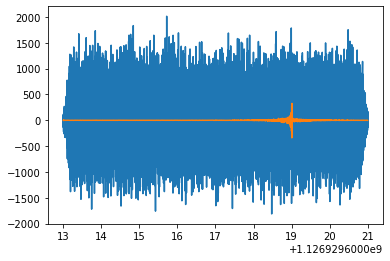

In [102]:
data = noise + signal

plt.plot(time_array, data)
plt.plot(time_array, signal)
data.size

In [103]:
wfd.parameters

{'mass_ratio': array([0.91520889]),
 'chirp_mass': array([28.57630523]),
 'luminosity_distance': array([648.3430391]),
 'dec': array([-1.27690905]),
 'ra': array([3.79809546]),
 'theta_jn': array([1.47215517]),
 'psi': array([0.84709182]),
 'phase': array([5.85122543]),
 'a_1': array([0.42257139]),
 'a_2': array([0.23225095]),
 'tilt_1': array([2.01470537]),
 'tilt_2': array([0.7475604]),
 'phi_12': array([5.9153709]),
 'phi_jl': array([5.30989175]),
 'geocent_time': array([1126929619])}

# Test on real events (on-source)

In [6]:
import sys
sys.path.append('..')
from gwtoolkit.gw import WaveformDataset
from gwtoolkit.torch import (WaveformDatasetTorch, Normalize_params, Patching_data, ToTensor)
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import itertools
import numpy

from gwtoolkit.gw.gwosc_cvmfs import getstrain_cvmfs, FileList
from gwtoolkit.utils import pickle_read
import scipy.signal
from bilby.core import utils
import matplotlib.pyplot as plt

In [7]:
# 1. Init for WaveformDataset
sampling_frequency = 4096     # [Hz], sampling rate
duration = 8                  # [sec], duration of a sample
conversion = 'BBH'
waveform_approximant = 'IMRPhenomPv2'
# waveform_approximant = 'SEOBNRv4P' ## TODO
# waveform_approximant = 'IMRPhenomPv2_NRTidal'
# waveform_approximant = 'IMRPhenomXP'
reference_frequency = 50.
minimum_frequency = 20.
waveform_arguments = dict(waveform_approximant=waveform_approximant,
                          reference_frequency=reference_frequency,
                          minimum_frequency=minimum_frequency)
base = 'bilby'
dets = ['H1', 'L1'][:1]

filename = '../tests/gw/demo.prior'   # default prior file

In [8]:
# waveform dataset
wfd = WaveformDataset(sampling_frequency=sampling_frequency,
                      duration=duration,
                      conversion=conversion)

wfd.load_prior_source_detector(
    filename=filename,
    base=base,
    dets=dets,
    waveform_arguments=waveform_arguments)

Using priors in ../tests/gw/demo.prior


In [6]:
data_dir = '/workspace/zhaoty/dataset/O1_H1_All/'
# 准备取 4096sec 真实数据的数据
wfd.dets['H1'].load_from_GWOSC(data_dir, 1024)
GWTC1_events = pickle_read('../gwtoolkit/gw/metadata/GWTC1_events.pkl')
filelist = FileList(directory=data_dir)
ifo = 'H1'

Using data directory /workspace/zhaoty/dataset/O1_H1_All/ ...


In [90]:
# GW151012 GW151226 GW150914
target_time = GWTC1_events['GW150914']['trigger-time'] 
PSD_strain, _, _, _ = getstrain_cvmfs(target_time - 6  -1024, target_time - 6  , ifo, filelist)
seg_sec = 0.1
freq, Pxx = scipy.signal.welch(PSD_strain, fs=sampling_frequency,
                               nperseg=seg_sec*sampling_frequency, )

# 
wfd.dets['H1'].ifo.power_spectral_density = wfd.dets['H1'].ifo.power_spectral_density.from_power_spectral_density_array(freq, Pxx)

In [91]:
start = target_time - 6         # step=0.5, -200 +50
strain, time, dqmask, injmask = getstrain_cvmfs(start, start+duration, ifo, filelist)
strain = strain[::4]
time = time[::4]
freq_domain_strain, freq = wfd.dets['H1'].time_to_frequency_domain(strain)
whiten_freq_domain_strain = freq_domain_strain / wfd.dets['H1'].amplitude_spectral_density_array
witen_time_domain_strain = utils.infft(whiten_freq_domain_strain, sampling_frequency)

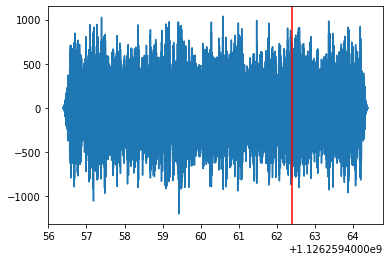

In [94]:
plt.plot(time, witen_time_domain_strain)
# plt.xlim(target_time-0.1, target_time+0.1)
plt.axvline(target_time, color='r')